#### Hello! Gonna try to explore Austin Airbnb data. We'll see what happens. Data from http://insideairbnb.com/get-the-data/
###### Will be using 4 different datasets, one of which is a GEO data set. Best of luck

In [1]:
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot
import geopandas as gpd

listings_df = pd.read_csv('C:/Users/aaron/Code/Data/austin_airbnb_listings.csv')
reviews_df = pd.read_csv('C:/Users/aaron/Code/Data/austin_airbnb_reviews.csv')
neighborhoods_df = pd.read_csv('C:/Users/aaron/Code/Data/austin_airbnb_neighbourhoods.csv')
geo_neighborhoods_df = gpd.read_file('C:/Users/aaron/Code/Data/austin_airbnb_GEO_neighbourhoods.geojson')


pd.set_option('display.max_columns', None) ### This line makes all the columns display, rather than ellipses shorten

In [2]:
listings_df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,5456,Guesthouse in Austin · ★4.84 · 1 bedroom · 2 b...,8028,Sylvia,NaN,78702,30.26057,-97.73441,Entire home/apt,101.0,2,668,2023-11-20,3.71,1,330,47,NaN
1,5769,Home in Austin · ★4.91 · 1 bedroom · 1 bed · 1...,8186,Elizabeth,NaN,78729,30.45697,-97.78422,Private room,NaN,1,294,2023-12-07,1.76,1,0,20,NaN
2,218402,Home in Austin · ★4.74 · 1 bedroom · 1 bed · 1...,1129520,Paulette,NaN,78754,30.36145,-97.64397,Private room,30.0,28,29,2023-09-24,0.20,1,252,2,NaN
3,6413,Guesthouse in Austin · ★4.97 · Studio · 1 bed ...,13879,Todd,NaN,78704,30.24885,-97.73587,Entire home/apt,NaN,30,120,2022-10-17,0.70,1,0,0,NaN
4,6448,Guesthouse in Austin · ★4.97 · 1 bedroom · 2 b...,14156,Amy,NaN,78704,30.26034,-97.76487,Entire home/apt,159.0,3,312,2023-12-04,2.09,1,160,21,NaN


In [3]:
### rename some columns
listings_df = listings_df.rename(columns={'neighbourhood':'zip_code'})

In [4]:
#### make a new listings frame only including listings with the price.

price_frame = listings_df[listings_df['price'].notnull()]

In [5]:
listings_df['zip_code'].nunique()

44

In [6]:
#price_frame['price'].max()

price_frame.loc[price_frame['price'] == 38143.0]

,id,name,host_id,host_name,neighbourhood_group,zip_code,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
8425,567281208428241281,Villa in Austin · 11 bedrooms · 16 beds · 11.5...,210733801,Above Vacation,NaN,78732,30.34875,-97.87525,Entire home/apt,38143.0,2,0,NaN,NaN,44,364,0,NaN


Text(0.5, 1.0, 'All Austin Airbnb Locations')

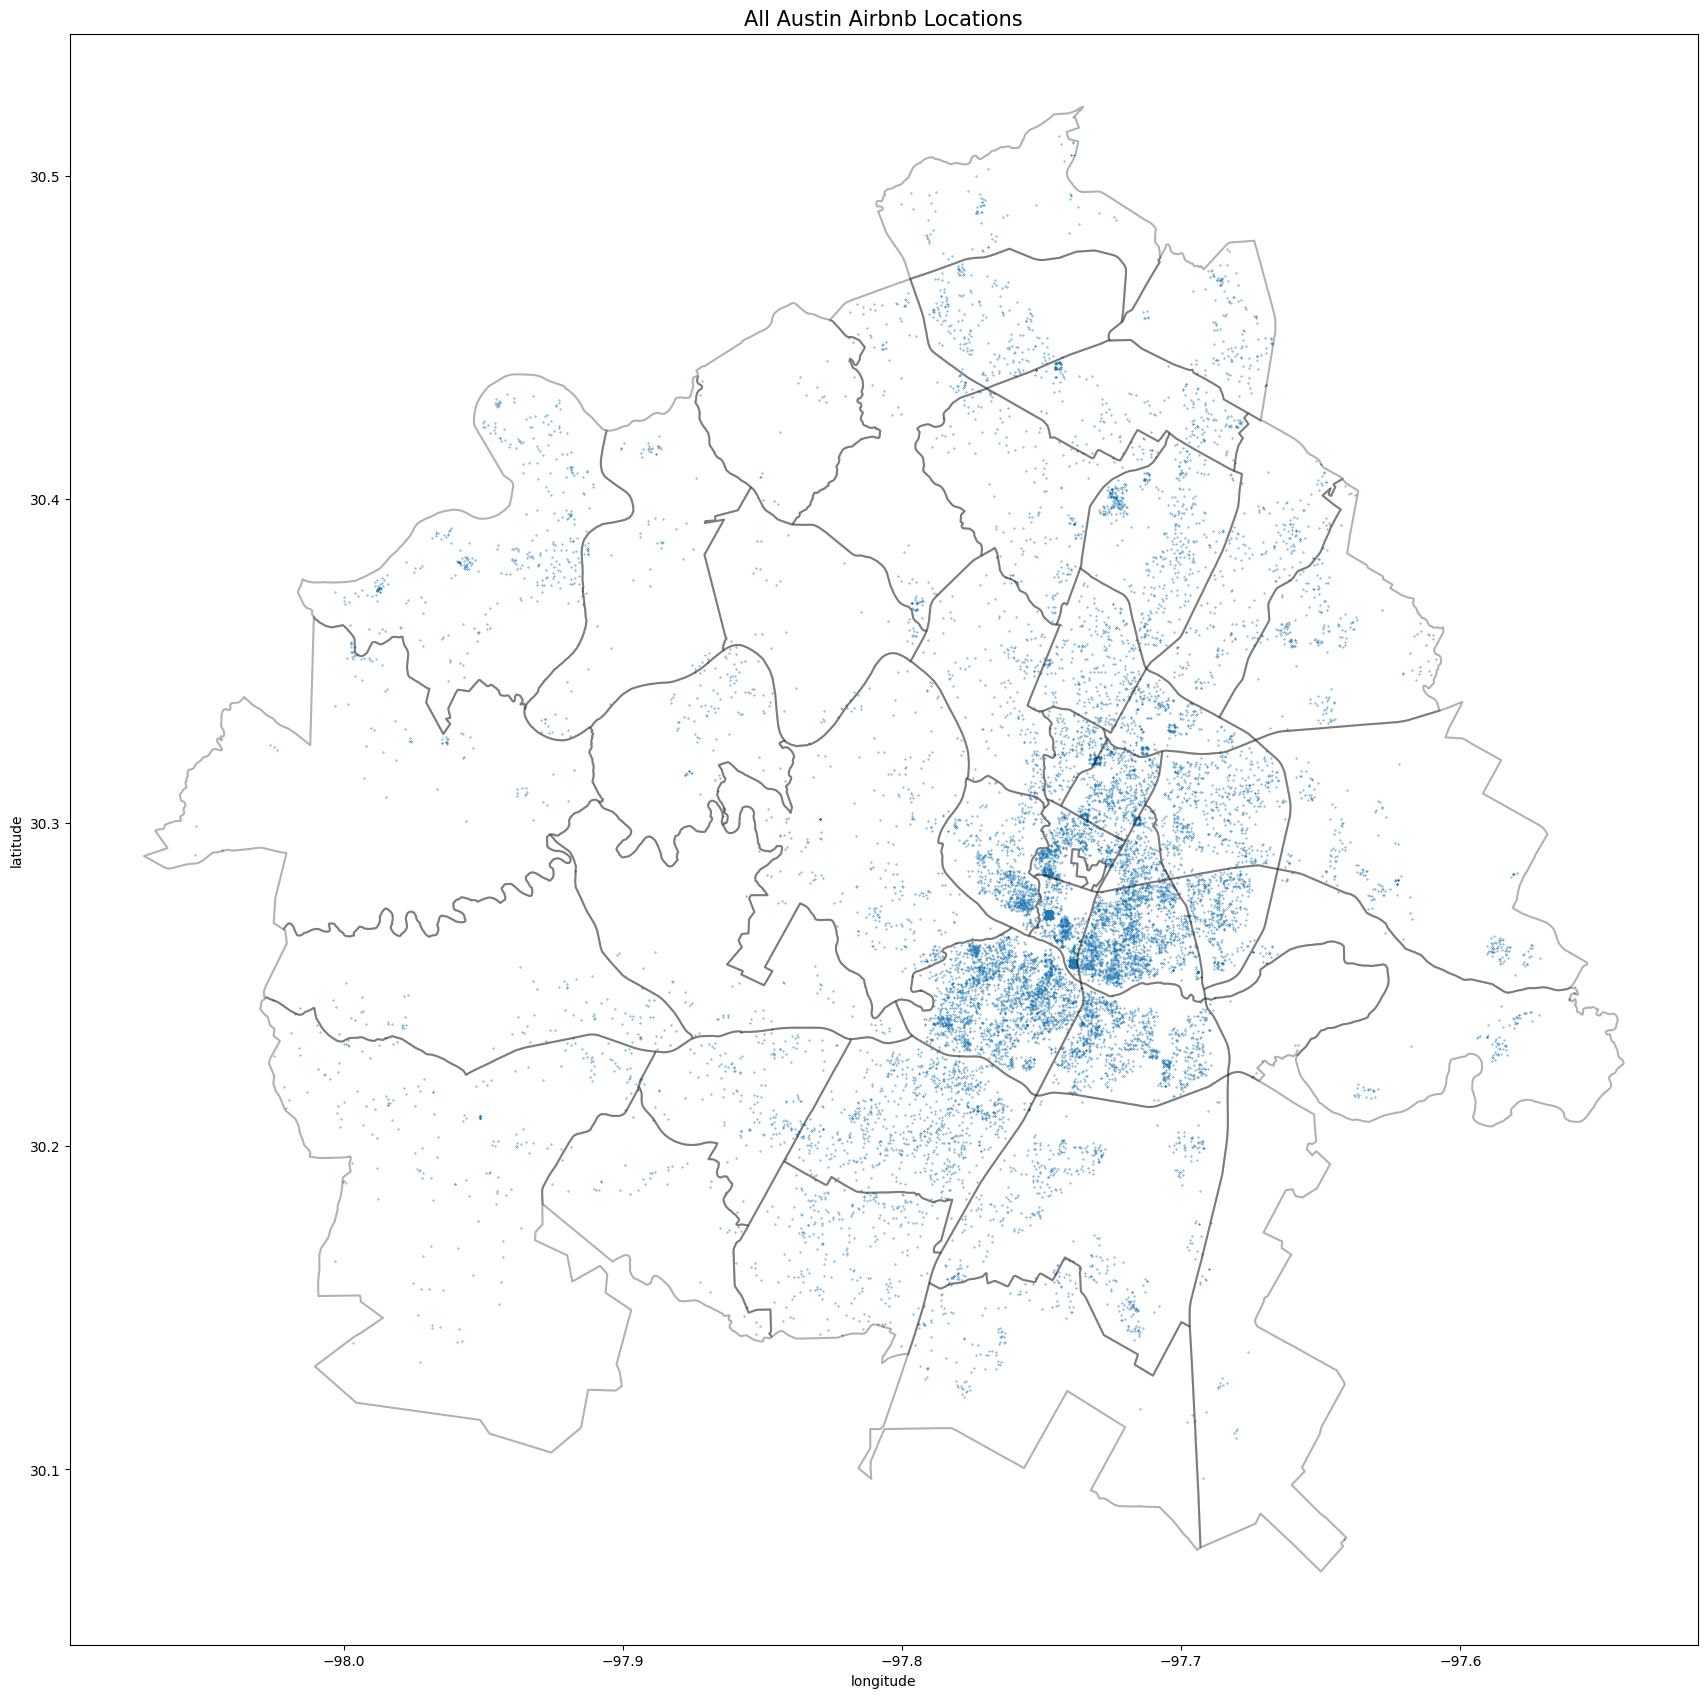

In [7]:
fig, ax = plt.pyplot.subplots(figsize  = (21, 21))

listings_df.plot(x = 'longitude', y = 'latitude', kind='scatter', s = 0.1, legend = True, ax = ax)
geo_neighborhoods_df.boundary.plot(color = 'black', alpha=0.3, ax = ax) ##alpha controls the opacity of the lines

ax.set_title("All Austin Airbnb Locations", fontsize=15)

In [8]:
#### merge this with price frame and neighborhoods frame on the neighbourhood column
geo_neighborhoods_df = geo_neighborhoods_df.astype({'neighbourhood':'int64'})


primary_frame = pd.merge(left = price_frame, right = geo_neighborhoods_df, left_on = 'zip_code', right_on = 'neighbourhood', how = 'left')

primary_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12291 entries, 0 to 12290
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   id                              12291 non-null  int64   
 1   name                            12291 non-null  object  
 2   host_id                         12291 non-null  int64   
 3   host_name                       12290 non-null  object  
 4   neighbourhood_group_x           0 non-null      float64 
 5   zip_code                        12291 non-null  int64   
 6   latitude                        12291 non-null  float64 
 7   longitude                       12291 non-null  float64 
 8   room_type                       12291 non-null  object  
 9   price                           12291 non-null  float64 
 10  minimum_nights                  12291 non-null  int64   
 11  number_of_reviews               12291 non-null  int64   
 12  last_review       

In [9]:
### make a gdf of type gdf
primary_geo_frame = gpd.GeoDataFrame(primary_frame, geometry='geometry')

In [10]:
price_by_zip = primary_geo_frame.groupby('zip_code').agg({'price':'mean', 'id':'count'}).reset_index()

In [11]:
## merge the price by zip with the geo frame
price_by_zip_geo = pd.merge(left = price_by_zip, right = geo_neighborhoods_df, left_on = 'zip_code', right_on = 'neighbourhood', how = 'inner')
price_by_zip_geo = gpd.GeoDataFrame(price_by_zip_geo)
#price_by_zip

In [21]:
##This sets the map to a variable! to display just dont assign, or print the variable

price_by_zip_geo = price_by_zip_geo.rename(columns={'id':'Listings in Zip', 'zip_code':'Zip Code', 'price':'Price'})
price_by_zip_geo = price_by_zip_geo.round({'price': 1})

austin_zip_map = price_by_zip_geo.explore(
    column = 'Price',
    tooltip = ['Price', 'Zip Code', 'Listings in Zip'],
    style_kwds=dict(color="black"),
    legend = True,
    title = 'Austin Airbnb Prices'
)

austin_zip_map

In [13]:
austin_zip_map.save('Austin_Airbnb_Prices_by_Zip.html') ### this worked! Successfully saved the map 

Text(0.5, 1.0, 'Austin Airbnb prices by Zip Code')

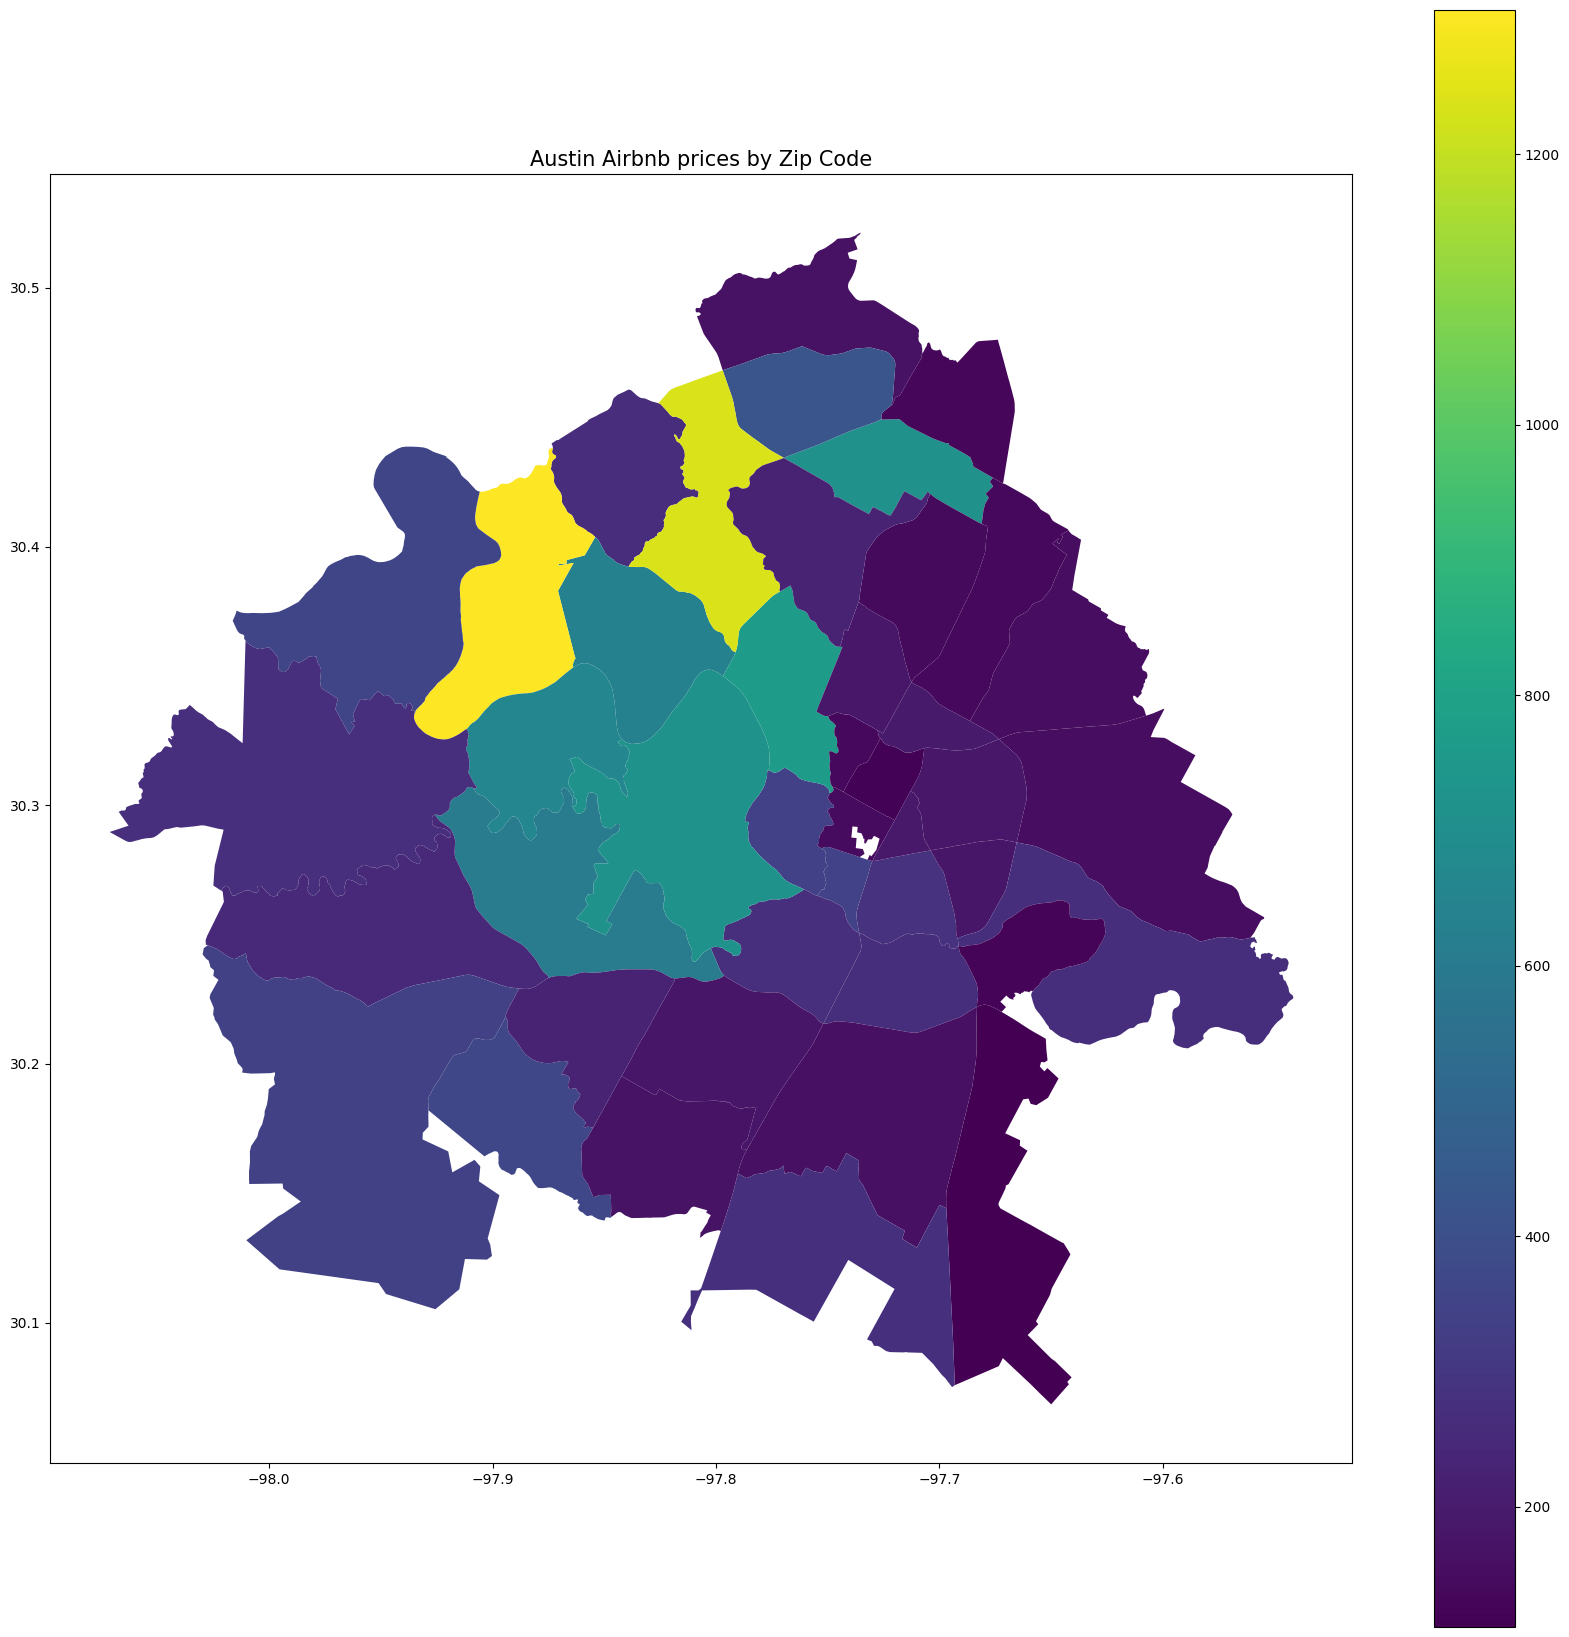

In [14]:
fig, ax = plt.pyplot.subplots(figsize  = (21, 21))

price_by_zip_geo.plot(column='price', legend = True, ax = ax)

ax.set_title("Austin Airbnb prices by Zip Code", fontsize=15)